In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as sk
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import sklearn.ensemble as ensemble
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_validate, KFold
from tensorflow.keras.utils import to_categorical

2024-09-25 13:59:47.106455: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 13:59:47.107740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 13:59:47.129620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 13:59:47.130225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Specify the file path
file_path = "../data/p02_combined.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, low_memory=False)

# Display the DataFrame
df.head()

,ts,timestamp,frame,face_id,confidence_x,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,...,local_orientation_per_joint_32_1,local_orientation_per_joint_32_2,local_orientation_per_joint_32_3,local_orientation_per_joint_33_0,local_orientation_per_joint_33_1,local_orientation_per_joint_33_2,local_orientation_per_joint_33_3,confused,help,name
0,0.000,0.000,1,0,0.98,1,0.250167,0.231496,-0.940120,0.096051,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,p02
1,0.033,0.033,2,0,0.98,1,0.242963,0.228393,-0.942765,0.094555,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,p02
2,0.067,0.067,3,0,0.98,1,0.243971,0.225870,-0.943112,0.097189,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,p02
3,0.100,0.100,4,0,0.98,1,0.240007,0.224554,-0.944443,0.095567,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,p02
4,0.134,0.133,5,0,0.98,1,0.240607,0.223447,-0.944553,0.096990,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,p02


In [4]:
df.shape

(57292, 1103)

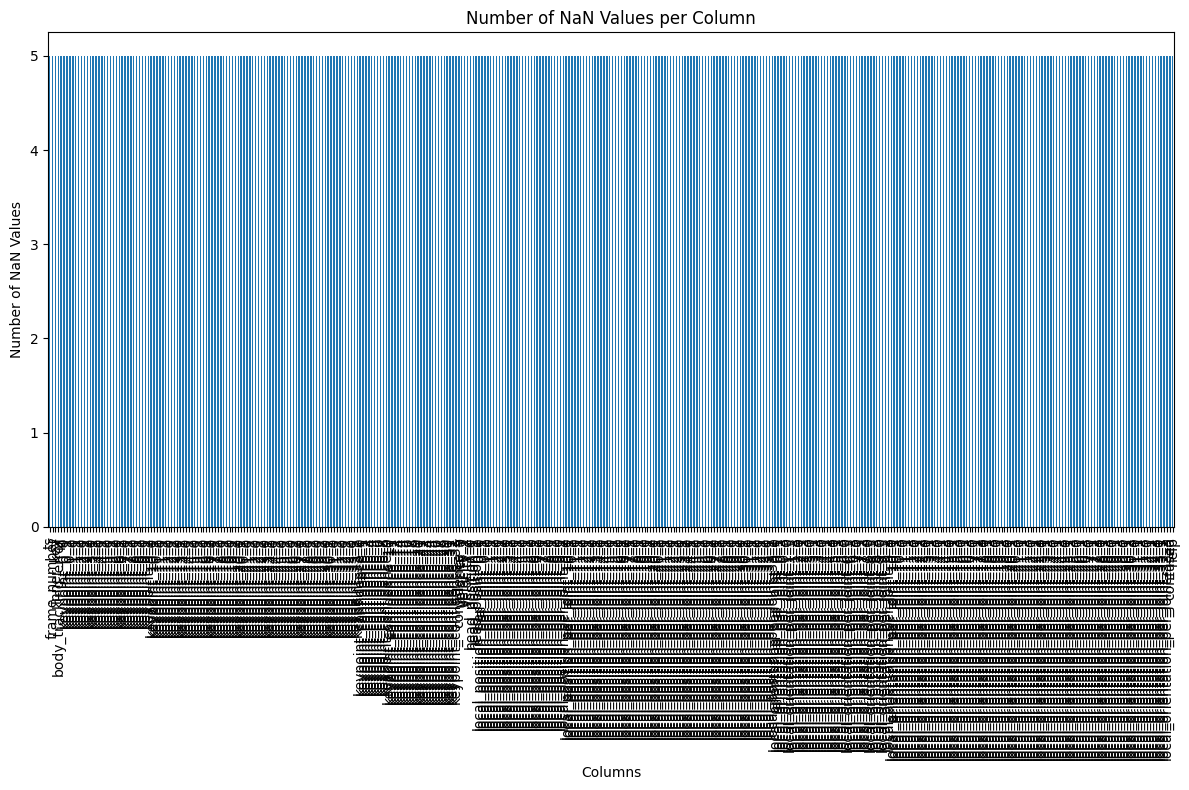

Series([], dtype: int64)

In [5]:
# Display the shape of the DataFrame
columns_with_nan = df.columns[df.isna().any()].tolist()

# Calculate the number of NaN values for each column with NaNs
nan_counts = df[columns_with_nan].isna().sum()

# Create a bar plot for columns with NaN counts
plt.figure(figsize=(12, 8))
nan_counts.plot(kind='bar')
plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display columns THAT HAVE 'id' in their name
#x_columns = df.filter(regex=r'.*', axis=1).columns.tolist()
#x_columns

# Show column names with NaN values and their counts
nan_counts[nan_counts>200]

In [6]:
# Clean the dat

# Declare label
label_confused = 'confused'
label_help = 'help'
label_both = 'both'
label_neither = 'neither'
label_either = 'either' # Help means you are confused and need help

labels = [label_confused, label_help, label_both, label_neither, label_either]

def clean(df):
    cols = ['body_tracking_error', 'confused', 'help']
    df = df.copy()

    # Define the patterns to filter out for body34
    patterns_to_remove_body34 = [
    r'keypoint_1[8-9]_.*',  # Matches keypoint_18_* and keypoint_19_*
    r'keypoint_2[0-5]_.*', # Matches keypoint_20_* to keypoint_29_*
    r'keypoint_3[2-3]_.*', # Matches keypoint_32_* to keypoint_33_*
    r'keypoint_confidence_1[8-9]',  # Matches keypoint_confidence_18 and keypoint_confidence_19
    r'keypoint_confidence_2[0-5]',  # Matches keypoint_confidence_20 to keypoint_confidence_29
    r'keypoint_confidence_3[2-3]', # Matches keypoint_confidence_32 to keypoint_confidence_33
    r'local_position_per_joint_1[8-9]_.*', # Matches local_position_per_joint_18_* and local_position_per_joint_19_*
    r'local_position_per_joint_2[0-5]_.*', # Matches local_position_per_joint_20_* to local_position_per_joint_29_*
    r'local_position_per_joint_3[2-3]_.*', # Matches local_position_per_joint_32_* to local_position_per_joint_33_*
    r'local_orientation_per_joint_1[8-9]_.*', # Matches local_orientation_per_joint_18_* and local_orientation_per_joint_19_*
    r'local_orientation_per_joint_2[0-5]_.*', # Matches local_orientation_per_joint_20_* to local_orientation_per_joint_29_*
    r'local_orientation_per_joint_3[2-3]_.*'  # Matches local_orientation_per_joint_32_* to local_orientation_per_joint_33_*
    ]

    # Combine patterns into a single regex pattern
    combined_pattern = '|'.join(patterns_to_remove_body34)

    # Filter columns based on the combined pattern
    filtered_columns = df.filter(regex=f'^((?!{combined_pattern}).)*$', axis=1)

    # Assign back to df
    df = df[filtered_columns.columns]

    # drop columns with NaN values in cols
    df = df.dropna(subset=cols)
    for col in cols:
        df[col] = df[col].replace(['False', 'True', '0.0', '1.0'], ['0', '1', '0', '1'])  # Replace string values with integers
        df[col] = df[col].astype('Int64')  # Use 'Int64' for nullable integers in pandas

    # Filter data based on confusion status
    df[label_both] = (df[label_confused] == 1) & (df[label_help] == 1)
    df[label_neither] = (df[label_confused] == 0) & (df[label_help] == 0)
    df[label_either] = (df[label_confused] == 1) | (df[label_help] == 1)
    df[label_confused] = (df[label_confused] == 1) & (df[label_help] == 0)
    df[label_help] = (df[label_help] == 1) & (df[label_confused] == 0)

    #df = df.dropna()
    #return df[(df["body_tracking_error"] == 0) & (df["success"] == 1)]
    return df[(df["body_tracking_error"] == 0)]

def lost_metrics(df, df_filtered):
    # Lost Frames
    print("Original df: ", df.shape)
    print("Filtered df: ", df_filtered.shape)
    print("Lost Frames: ", df.shape[0] - df_filtered.shape[0])
    print()

    for label in labels:
        # Calculate the truth percentage of the total
        if label == label_neither:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(0, 0)) * 100
        else:
            truth_percentage = (df_filtered[label].value_counts(normalize=True).get(1, 0)) * 100

        # Display the label and its truth percentage
        print(f'{label}: {truth_percentage:.2f}%')

        # Display the value counts for the label
        value_counts = df_filtered[label].value_counts()
        print(value_counts.to_string(), "\n")  # Converts the Series to a string to format it nicely

    try:
        # Display the shape of the DataFrame
        columns_with_nan = df_filtered.columns[df.isna().any()].tolist()

        # Calculate the number of NaN values for each column with NaNs
        nan_counts = df_filtered[columns_with_nan].isna().sum()

        # Create a bar plot for columns with NaN counts
        plt.figure(figsize=(12, 8))
        nan_counts.plot(kind='bar')
        plt.title('Number of NaN Values per Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of NaN Values')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    except:
        print("No NaN values")


# Clean the data
df_filtered = clean(df)

# Display lost metrics
lost_metrics(df, df_filtered)

Original df:  (57292, 1103)
Filtered df:  (57287, 996)
Lost Frames:  5

confused: 21.29%
confused
False    45093
True     12194 

help: 14.21%
help
False    49146
True      8141 

both: 0.11%
both
False    57226
True        61 

neither: 64.50%
neither
True     36952
False    20335 

either: 35.50%
either
False    36952
True     20335 

No NaN values


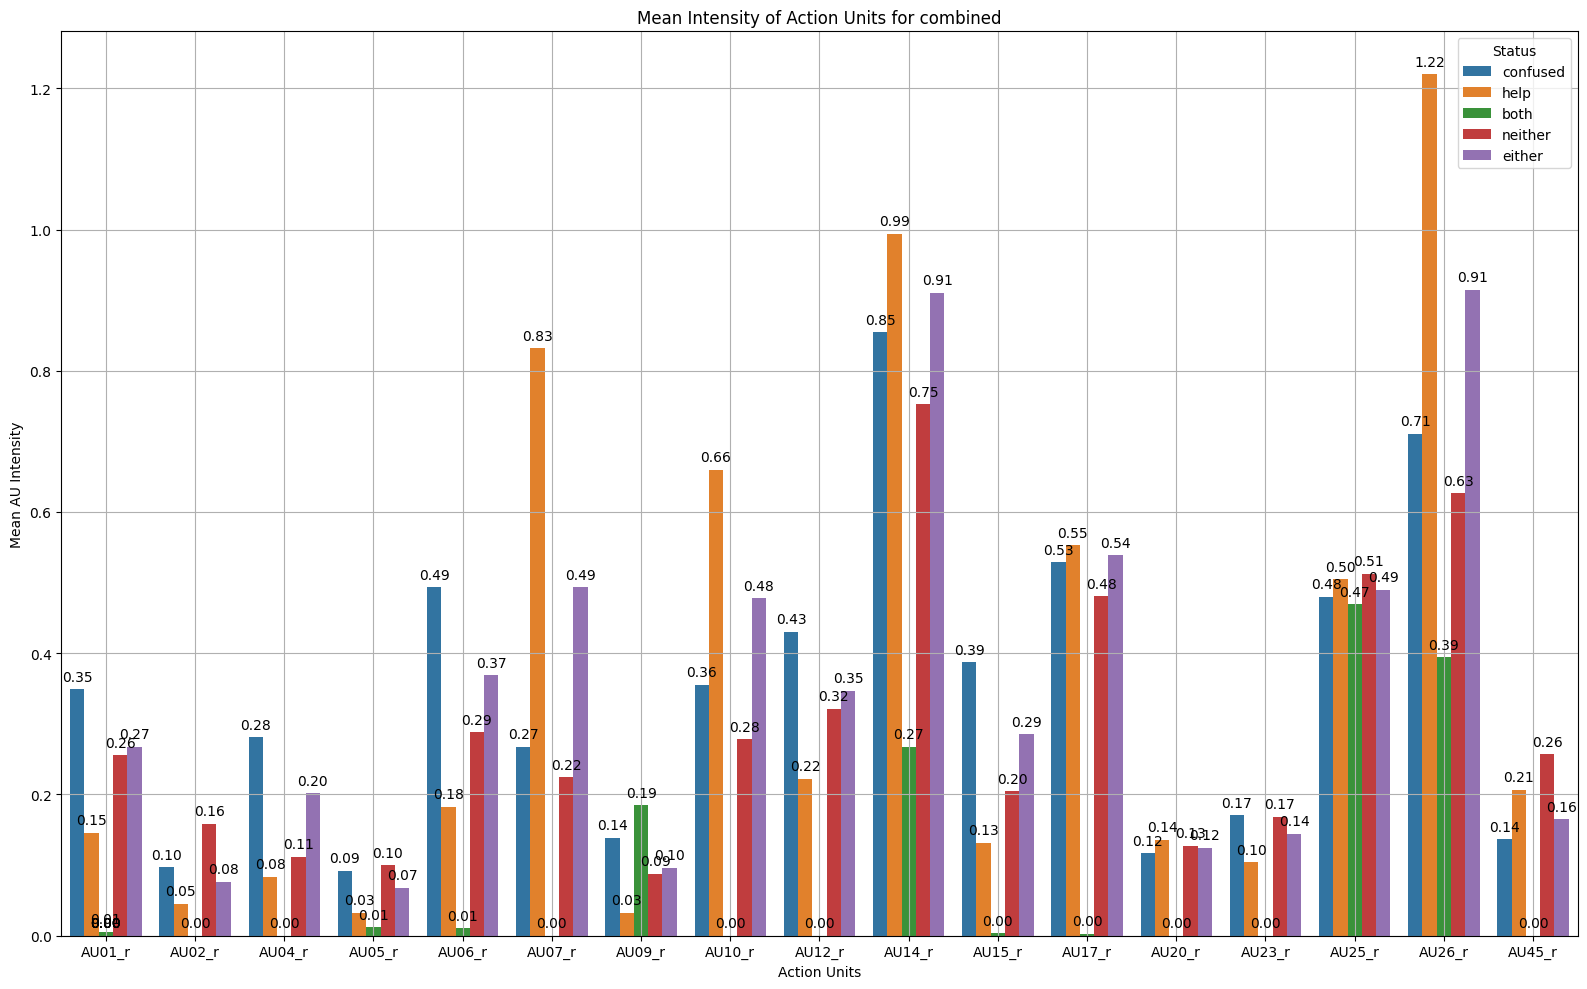

In [7]:
# Plot AU Intensity

# Facial Action Units (AUs) Intensity
au_columns_r = df_filtered.filter(regex=r'^AU\d{2}_r', axis=1).columns.tolist()

# Facial Action Units (AUs) Presence
au_columns_c = df_filtered.filter(regex=r'^AU\d{2}_c', axis=1).columns.tolist()

# Function to calculate mean activations for different labels
def calculate_mean_activations(df):
    mean_activations = {'AU': au_columns_r}
    for label in labels:
        mean_activations[label] = df[df[label] == 1][au_columns_r].mean()
    return mean_activations

# Plotting function
def plot_mean_activations(name, df):
    # Create a new dataframe for visualization
    mean_activations = calculate_mean_activations(df)
    df_means = pd.DataFrame(mean_activations).set_index('AU')

    # Reset the index to plot with seaborn
    df_means_reset = df_means.reset_index().melt(id_vars='AU', var_name='Status', value_name='Mean AU Intensity')

    # Plotting the data with Seaborn
    plt.figure(figsize=(16, 10))
    sns.barplot(x='AU', y='Mean AU Intensity', hue='Status', data=df_means_reset)

    # Add value labels to each bar
    for p in plt.gca().patches:
        plt.gca().annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    plt.xlabel('Action Units')
    plt.ylabel('Mean AU Intensity')
    plt.title('Mean Intensity of Action Units for ' + name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate and plot mean activations
plot_mean_activations("combined", df_filtered)

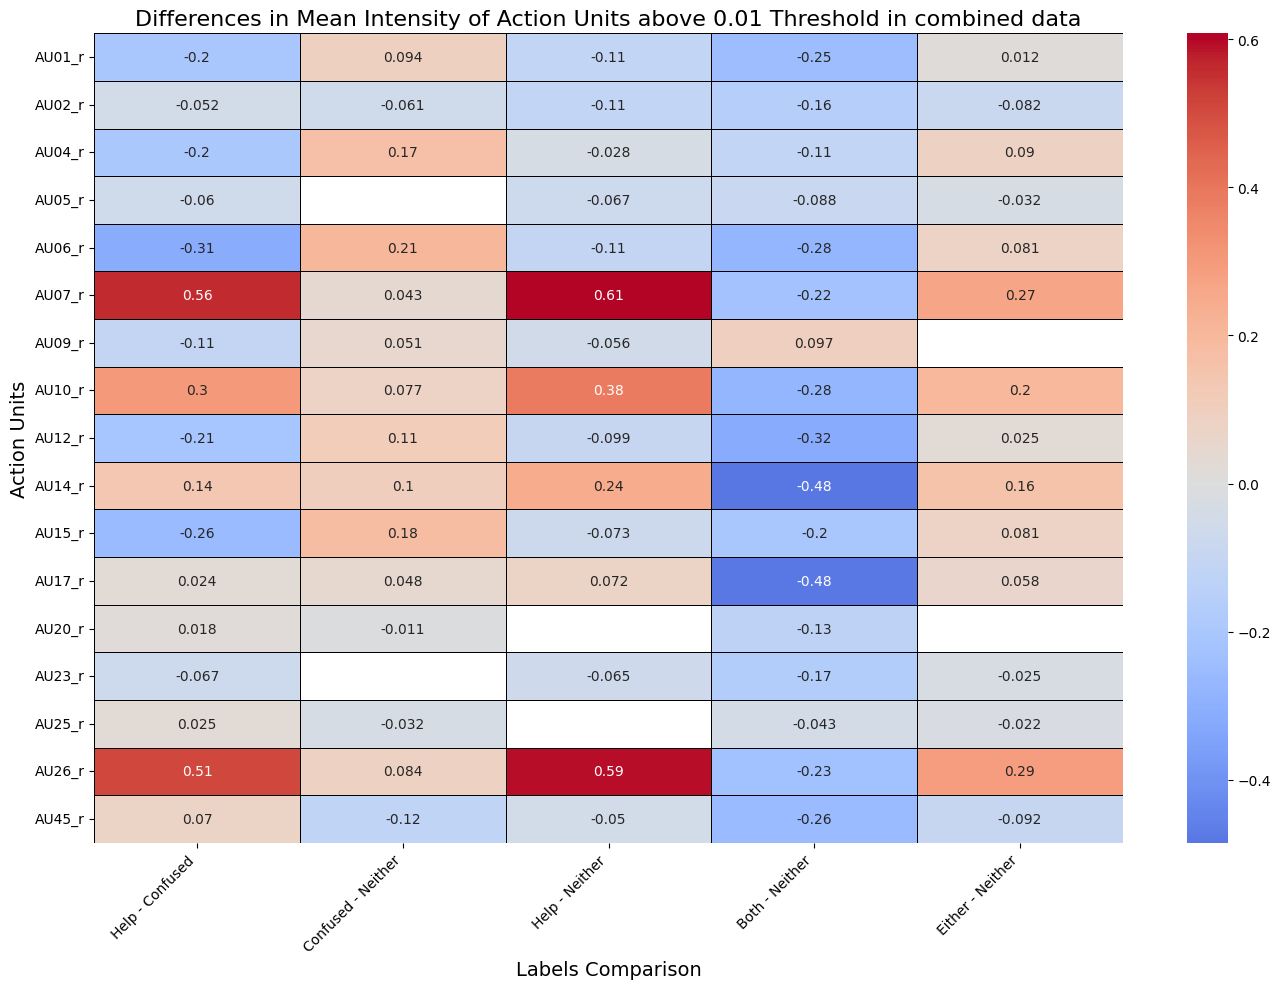

In [8]:
# Plot AU Intensity Difference Heatmap
# Function to calculate mean activations for different labels
def calculate_mean_activations(df):
    mean_activations = {'AU': au_columns_r}
    for label in labels:
        mean_activations[label] = df[df[label] == 1][au_columns_r].mean()
    return mean_activations

# Function to calculate differences
def calculate_differences(df_filtered):
    mean_activations_df_filtered = calculate_mean_activations(df_filtered)
    mean_confused = mean_activations_df_filtered[label_confused]
    mean_help = mean_activations_df_filtered[label_help]
    mean_both = mean_activations_df_filtered[label_both]
    mean_neither = mean_activations_df_filtered[label_neither]
    mean_either = mean_activations_df_filtered[label_either]

    diff_help_confused = mean_help - mean_confused
    diff_confused_neither = mean_confused - mean_neither
    diff_help_neither = mean_help - mean_neither
    diff_both_neither = mean_both - mean_neither
    diff_either_neither = mean_either - mean_neither

    return pd.DataFrame({
        'AU': au_columns_r,
        'Help - Confused': diff_help_confused,
        'Confused - Neither': diff_confused_neither,
        'Help - Neither': diff_help_neither,
        'Both - Neither': diff_both_neither,
        'Either - Neither': diff_either_neither
    }).set_index('AU')
    
def plot_au_diff_threshold_intensity_heatmap(name, df_filtered, threshold=0.15):

    # Create a new DataFrame for visualization
    df_differences = calculate_differences(df_filtered)
    
    # Plotting differences above a threshold
    df_differences_threshold = df_differences[(df_differences > threshold) | (df_differences < -threshold)]
    plt.figure(figsize=(14, 10))
    sns.heatmap(df_differences_threshold, annot=True, cmap='coolwarm', center=0, linewidths=.5, linecolor='black')
    plt.title(f'Differences in Mean Intensity of Action Units above {threshold} Threshold in {name} data', fontsize=16)
    plt.xlabel('Labels Comparison', fontsize=14)
    plt.ylabel('Action Units', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the heatmap
#plot_au_diff_intensity_heatmap("combined", df_filtered)
plot_au_diff_threshold_intensity_heatmap("combined", df_filtered, threshold=0.01)

In [9]:
# ADD SMOTE

In [10]:
# Split and standardize the data

def split_standardize_data(df):
    # Dropping columns that are not needed
    # List of columns to drop
    columns_to_drop = ['success', 'body_tracking_error', 'face_id', 'timestamp', 'id', 'ts', 'frame', 'frame_number', 'name'] + labels

    # Dropping columns that are not needed
    X = df_filtered.drop(columns=columns_to_drop)

    # Create a single column for y with multi-class labels
    y = df_filtered.apply(lambda row: label_both if row[label_both] == 1 else 
                                        label_help if row[label_help] == 1 else 
                                        label_confused if row[label_confused] == 1 else 
                                        label_neither, axis=1)

    # Drop any remaining non-numeric columns
    X = X.select_dtypes(include=['number'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Convert y to numeric multi-class values using LabelEncoder
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Decode the labels back to original labels
    y_train_labels = label_encoder.inverse_transform(y_train)
    y_test_labels = label_encoder.inverse_transform(y_test)

    # Create a StandardScaler object
    scaler = preprocessing.StandardScaler()

    # Fit the scaler to the training data and transform the training data
    X_train = scaler.fit_transform(X_train)

    # Transform the testing data
    X_test = scaler.transform(X_test)

    # Print number of y_test values in each class
    print("\nNumber of classes")
    print("\nTraining set class distribution (y_train): ", len(y_train))
    print(pd.Series(y_train_labels).value_counts().to_string())

    print("\nTesting class distribution (y_pred):", len(y_test_labels))
    print(pd.Series(y_test_labels).value_counts().to_string())

    return X_train, X_test, y_train, y_test, y_train_labels, y_test_labels, label_encoder, scaler, X, y

# Split and standardize the data
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels, label_encoder, scaler, X, y = split_standardize_data(df_filtered)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


Number of classes

Training set class distribution (y_train):  38382
neither     24791
confused     8151
help         5400
both           40

Testing class distribution (y_pred): 18905
neither     12161
confused     4043
help         2680
both           21


((38382, 981), (18905, 981), (38382,), (18905,))

In [11]:
# XGBoost Classifier for Multi-Class Classification (Random Forest)

def xgb_classifier(X_train, y_train, X_test, y_test, label_encoder=label_encoder, scaler=scaler):
    # Create a XGBClassifier object with multi-class objective
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        reg_alpha=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    # Fit the classifier to the training data
    xgb_clf.fit(X_train, y_train)

    # Make predictions on the testing data
    y_rf_pred = xgb_clf.predict(X_test)

    return xgb_clf, y_rf_pred

# Train the XGBoost classifier
xgb_clf, y_rf_pred = xgb_classifier(X_train, y_train, X_test, y_test, label_encoder, scaler)

# Decode the labels back to original labels
y_rf_pred_labels = label_encoder.inverse_transform(y_rf_pred)

Epoch 1/30


2024-09-25 14:01:39.217044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-25 14:01:39.270452: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


804/804 [==============================] - 2s 2ms/step - loss: 0.3883 - accuracy: 0.8476 - val_loss: 0.2506 - val_accuracy: 0.9012
Epoch 2/30
804/804 [==============================] - 1s 2ms/step - loss: 0.1798 - accuracy: 0.9324 - val_loss: 0.1948 - val_accuracy: 0.9203
Epoch 3/30
804/804 [==============================] - 1s 2ms/step - loss: 0.1337 - accuracy: 0.9500 - val_loss: 0.1362 - val_accuracy: 0.9480
Epoch 4/30
804/804 [==============================] - 1s 2ms/step - loss: 0.1105 - accuracy: 0.9602 - val_loss: 0.1072 - val_accuracy: 0.9594
Epoch 5/30
804/804 [==============================] - 1s 2ms/step - loss: 0.0923 - accuracy: 0.9650 - val_loss: 0.0741 - val_accuracy: 0.9739
Epoch 6/30
804/804 [==============================] - 1s 2ms/step - loss: 0.0818 - accuracy: 0.9708 - val_loss: 0.0909 - val_accuracy: 0.9638
Epoch 7/30
804/804 [==============================] - 1s 2ms/step - loss: 0.0694 - accuracy: 0.9743 - val_loss: 0.0570 - val_accuracy: 0.9803
Epoch 8/30
804/80

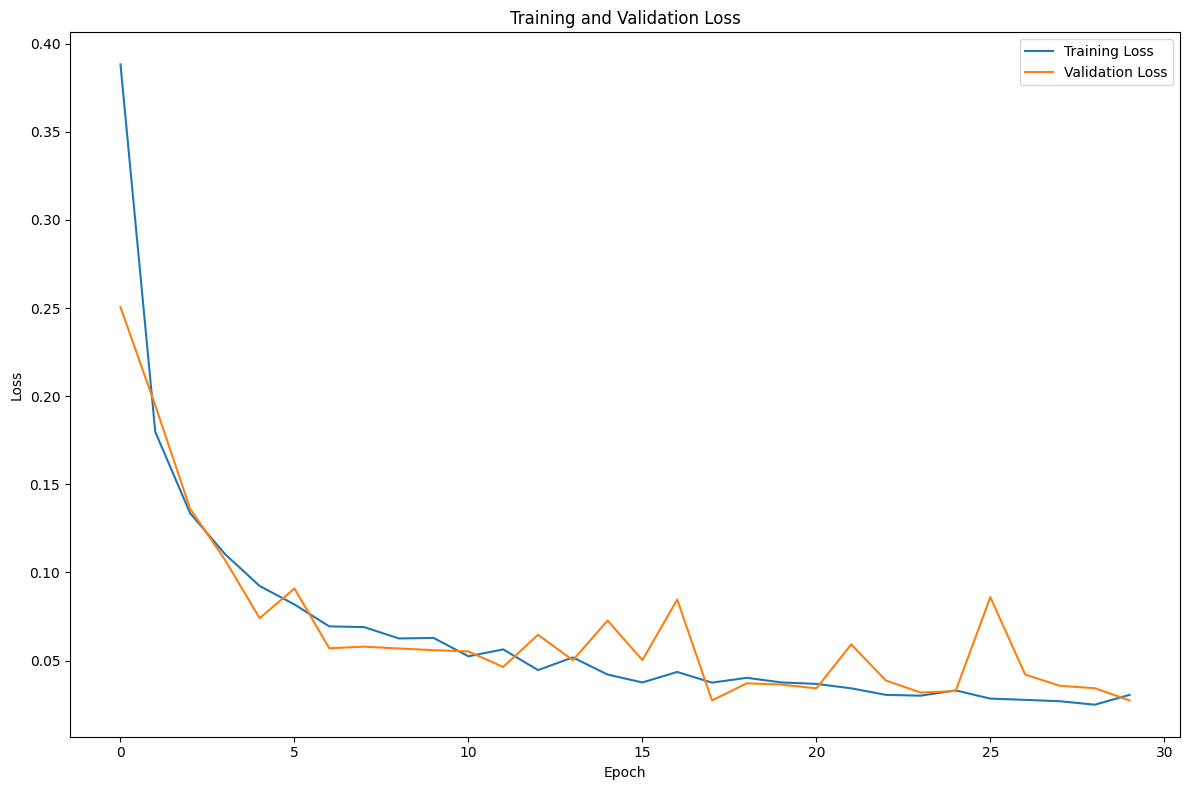

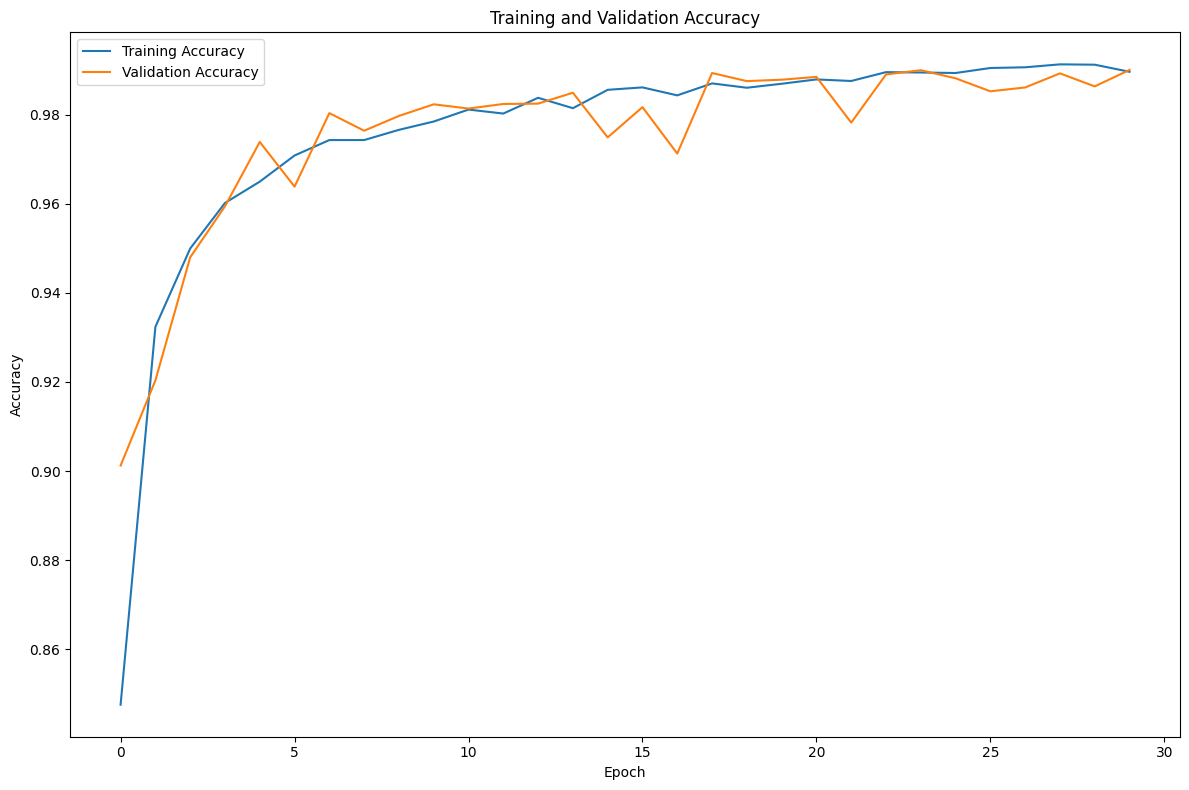

In [12]:
# Neural Network for Multi-Class Classification

def nn_classifier(X_train, y_train, X_test, y_test, num_classes=4):
    # Ensure y_train is one-hot encoded
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    # Create a Sequential model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.33, verbose=1)

    # Evaluate the model
    loss, accuracy_nn = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions on the testing data
    y_nn_pred = model.predict(X_test)

    # Convert the predictions to class labels
    y_nn_pred_labels = label_encoder.inverse_transform(np.argmax(y_nn_pred, axis=1))

    return model, history, accuracy_nn, y_nn_pred, y_nn_pred_labels

# Train the Neural Network classifier
model, history, accuracy_nn, y_nn_pred, y_nn_pred_labels = nn_classifier(X_train, y_train, X_test, y_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

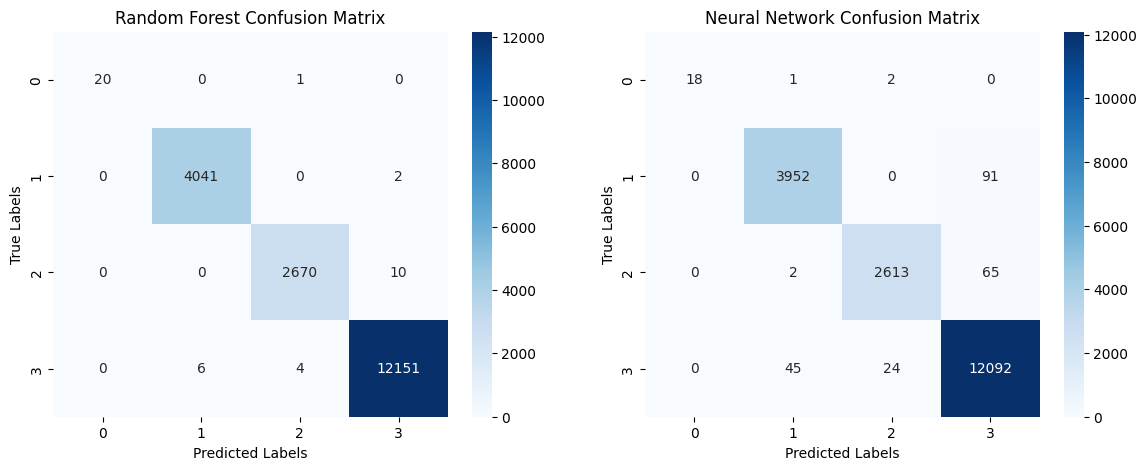

Random Forest Classification Report: 99.87833906373976% accuracy
              precision    recall  f1-score       support
both           1.000000  0.952381  0.975610     21.000000
confused       0.998517  0.999505  0.999011   4043.000000
help           0.998131  0.996269  0.997199   2680.000000
neither        0.999013  0.999178  0.999096  12161.000000
accuracy       0.998783  0.998783  0.998783      0.998783
macro avg      0.998915  0.986833  0.992729  18905.000000
weighted avg   0.998783  0.998783  0.998783  18905.000000

Neural Network Classification Report: 98.78339063739752% accuracy
              precision    recall  f1-score       support
both           1.000000  0.857143  0.923077     21.000000
confused       0.988000  0.977492  0.982718   4043.000000
help           0.990148  0.975000  0.982516   2680.000000
neither        0.987263  0.994326  0.990782  12161.000000
accuracy       0.987834  0.987834  0.987834      0.987834
macro avg      0.991353  0.950990  0.969773  18905.00000

In [13]:
def calculate_metrics(y_test_labels, y_pred_labels):
    # Calculate the accuracy of model
    accuracy = metrics.accuracy_score(y_test_labels, y_pred_labels)

    # Create confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

    # Create classification report
    class_report = metrics.classification_report(y_test_labels, y_pred_labels, output_dict=True)

    return accuracy, conf_matrix, class_report

accuracy_rf, conf_matrix_rf, class_report_rf = calculate_metrics(y_test_labels, y_rf_pred_labels)
accuracy_nn, conf_matrix_nn, class_report_nn = calculate_metrics(y_test_labels, y_nn_pred_labels)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Neural Network Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

# Display classification reports in a more readable format
class_report_rf_df = pd.DataFrame(class_report_rf).transpose()
class_report_nn_df = pd.DataFrame(class_report_nn).transpose()

print(f'Random Forest Classification Report: {accuracy_rf*100}% accuracy')
print(class_report_rf_df)
print()
print(f'Neural Network Classification Report: {accuracy_nn*100}% accuracy')
print(class_report_nn_df)

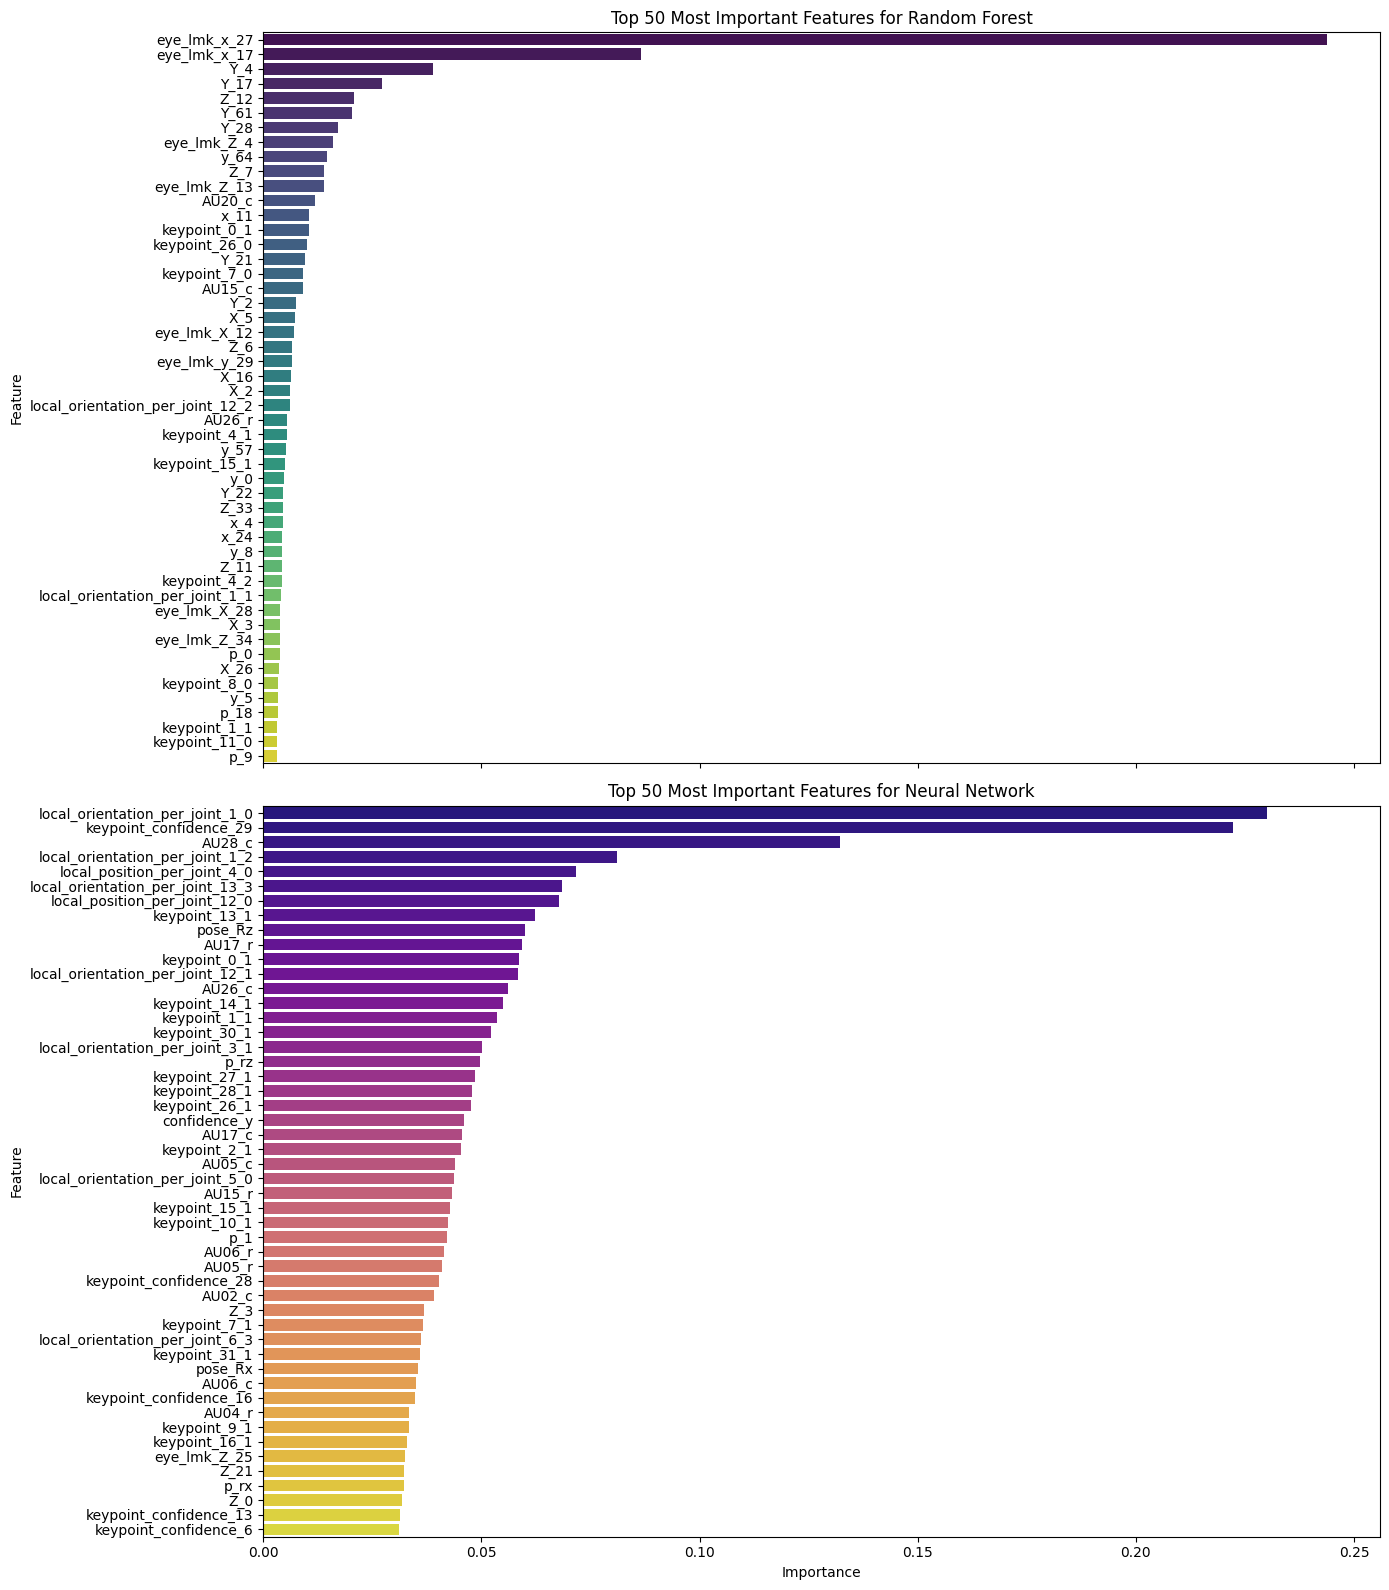

In [14]:
# Feature Importance Plot
n = 50

def plot_feature_importance(model, X):
    # Create a DataFrame to store the feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    top_n_feature_importances = feature_importances.nlargest(n, 'Importance')

    return top_n_feature_importances

# Plot the feature importances for the Neural Network model
def plot_nn_feature_importance(model, X):
    # Calculate the mean importance of each feature
    feature_importances = model.get_weights()[0].mean(axis=1)

    # Create a DataFrame to store the feature importances
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    top_n_feature_importances = feature_importances_df.nlargest(n, 'Importance')

    return top_n_feature_importances

# Plot the feature importances for the Random Forest model
top_features_rf = plot_feature_importance(xgb_clf, X)

# Plot the feature importances for the Neural Network model
top_features_nn = plot_nn_feature_importance(model, X)

# Plotting the top n feature importances for both models
fig, axes = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

# Random Forest plot
sns.barplot(x='Importance', y='Feature', data=top_features_rf, ax=axes[0], palette='viridis', hue='Feature')
axes[0].set_title(f'Top {n} Most Important Features for Random Forest')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')

# Neural Network plot
sns.barplot(x='Importance', y='Feature', data=top_features_nn, ax=axes[1], palette='plasma', hue='Feature')
axes[1].set_title(f'Top {n} Most Important Features for Neural Network')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

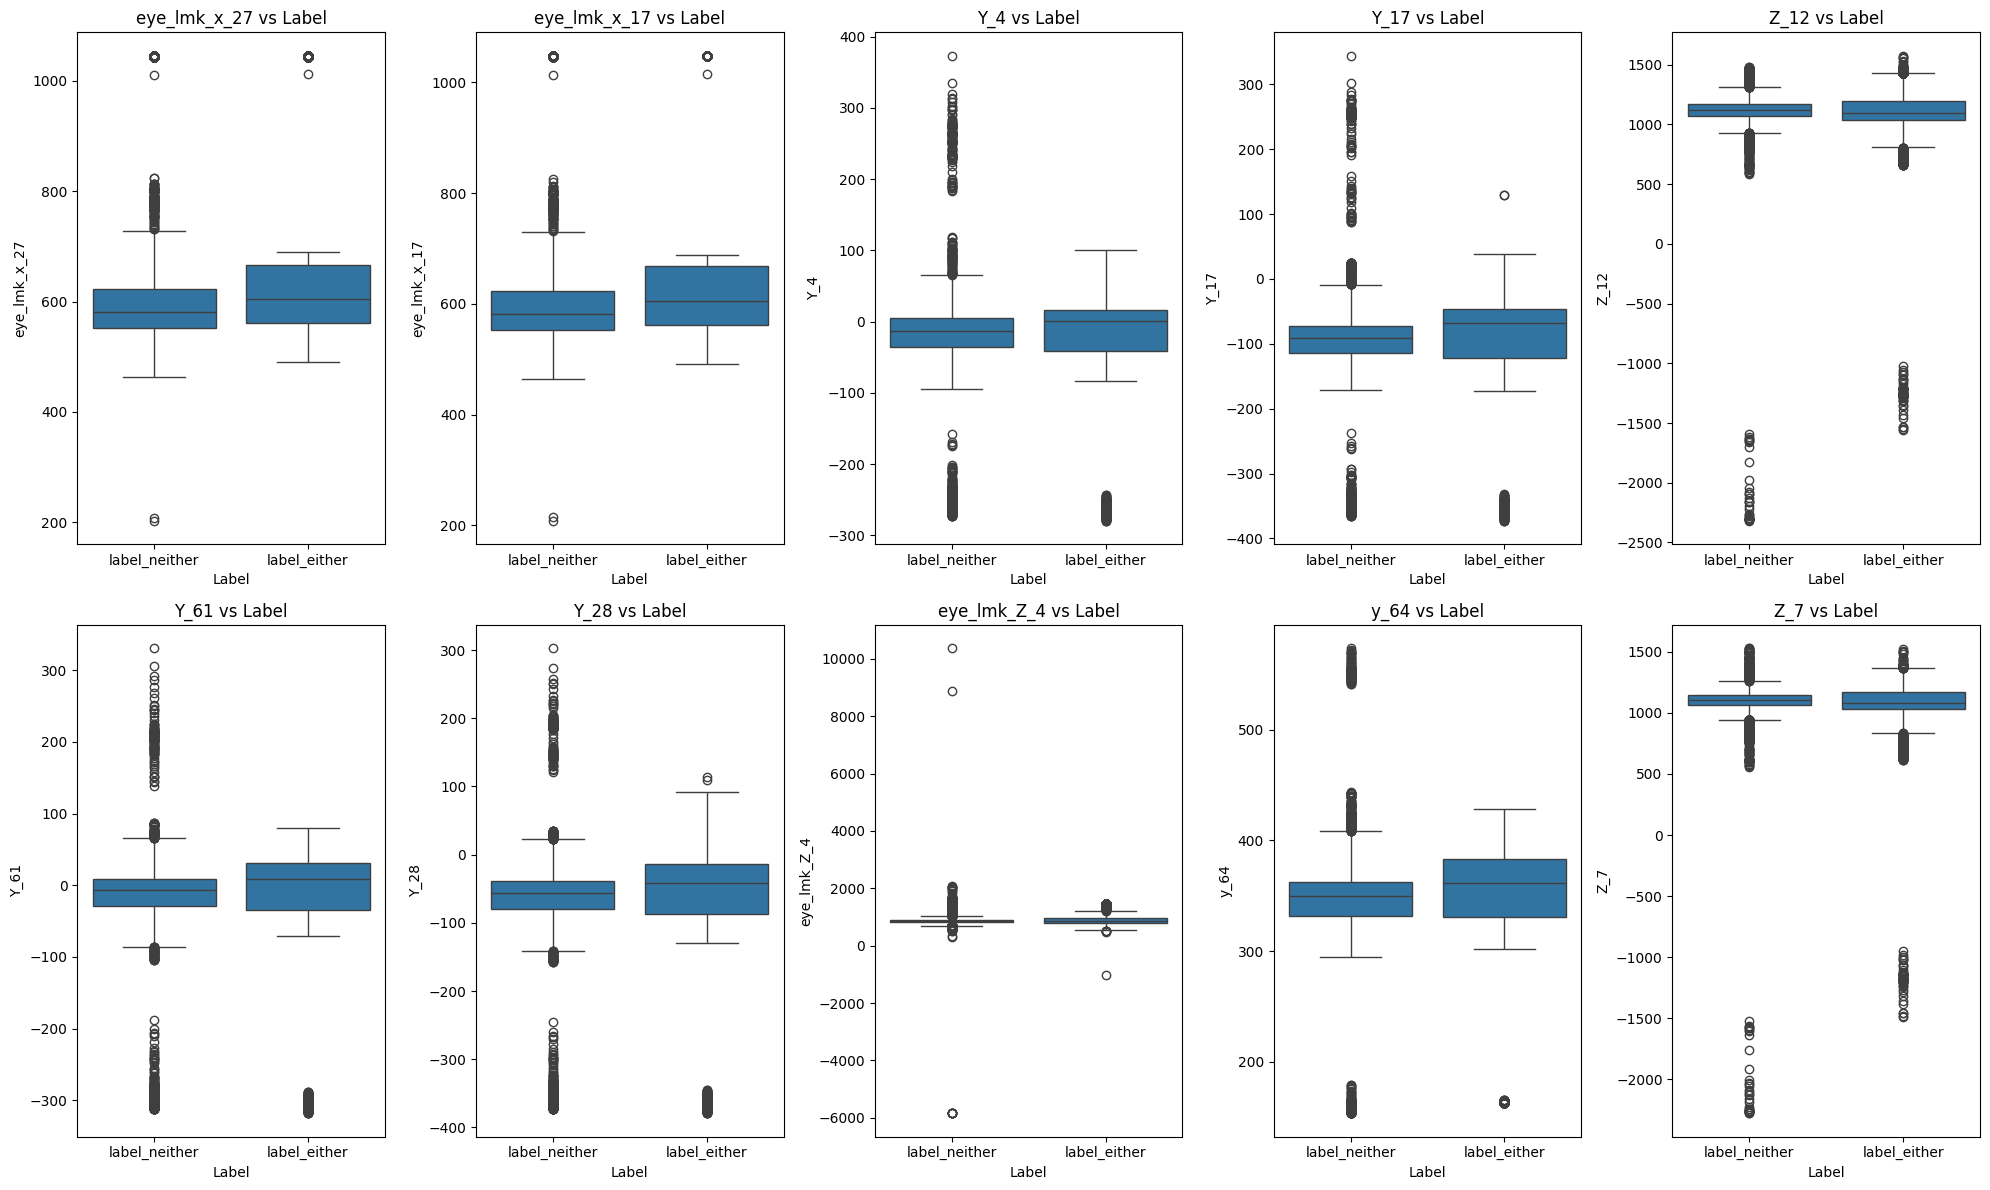

In [15]:
df_filtered['label_either'] = df_filtered[[label_confused, label_help, label_both]].max(axis=1)
df_filtered['label'] = df_filtered.apply(lambda row: 'label_either' if row['label_either'] == 1 else 'label_neither', axis=1)

# Assuming feature_importances_rf is your DataFrame
top_10_features = top_features_rf.nlargest(10, 'Importance')['Feature'].tolist()

# Melt the DataFrame to long format for top 10 features
df_long_top_10 = pd.melt(df_filtered, id_vars=["label"],
                         value_vars=top_10_features,
                         var_name="feature", value_name="value")

# Setting up the plot
num_features = len(top_10_features)
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

# Plotting each feature
for i, feature in enumerate(top_10_features):
    sns.boxplot(ax=axes[i], x='label', y='value', data=df_long_top_10[df_long_top_10['feature'] == feature])
    axes[i].set_title(f'{feature} vs Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(feature)

# Hide any unused subplots
for j in range(i + 1, 10):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

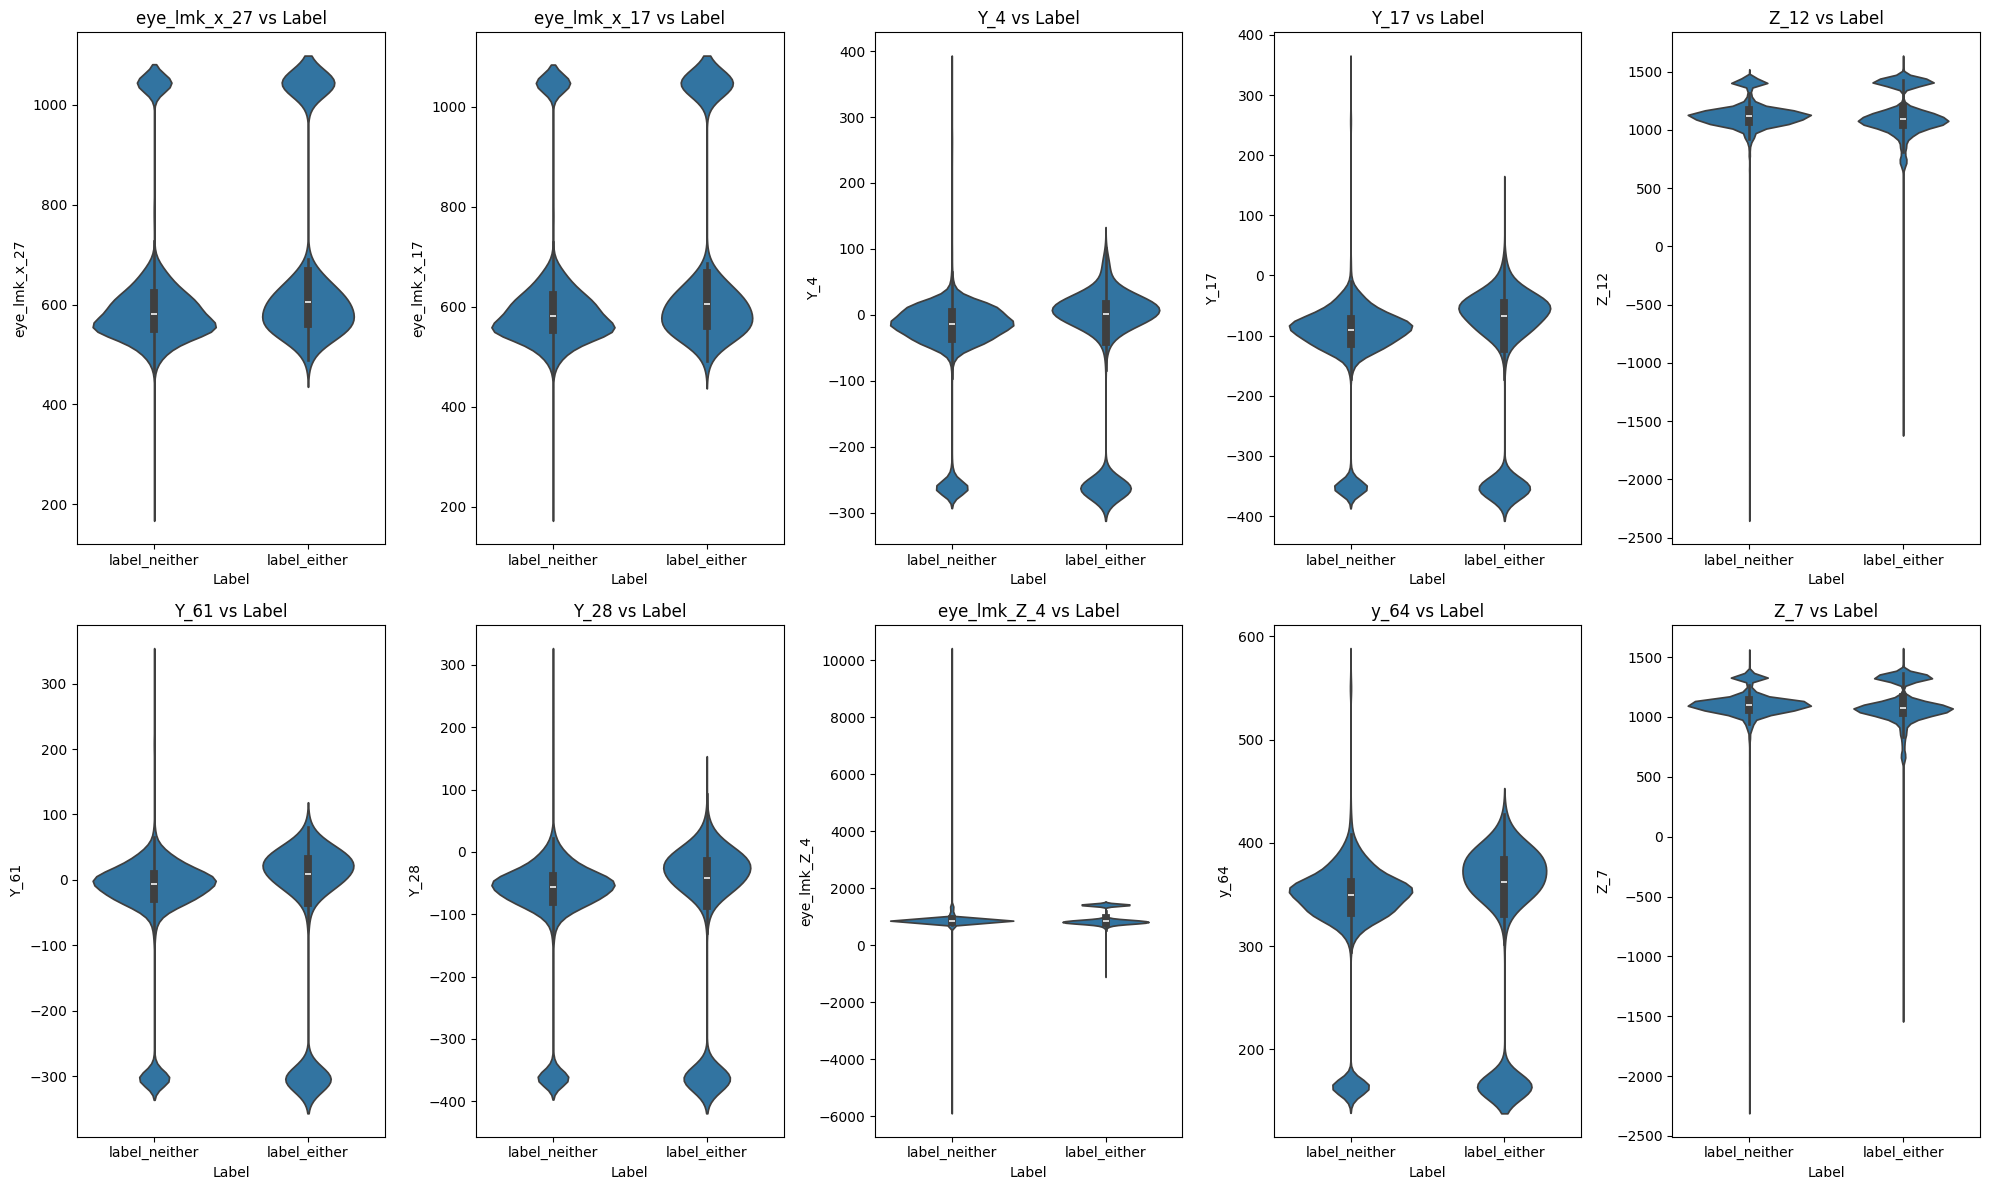

In [16]:
# Setting up the plot
fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.flatten()

# Plotting each feature
for i, feature in enumerate(top_10_features):
    sns.violinplot(ax=axes[i], x='label', y=feature, data=df_filtered)
    axes[i].set_title(f'{feature} vs Label')
    axes[i].set_xlabel('Label')
    axes[i].set_ylabel(feature)

# Hide any unused subplots
for j in range(i + 1, 10):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()